# Tests on sequences of data from AirSim

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy.spatial.transform import Rotation as R

import planeslam.geometry as geometry
import planeslam.io as io
from planeslam.plane import plane_to_plane_dist
from planeslam.extraction import pc_to_scan, pc_to_planes
from planeslam.rectangle import Rectangle

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes for LiDAR scans

In [5]:
# Extract scans and planesets
num_scans = len(PC_data)
scans = num_scans * [None]
planesets = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    # scans[i] = pc_to_scan(PC_data[i])
    # r = R.from_quat(drone_orientations[i,:])
    # scans[i].transform(r.as_matrix(), drone_positions[i,:])

    planesets[i] = pc_to_planes(PC_data[i])

In [ ]:
# Plot scans
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('viridis')
cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, s in enumerate(scans):
    s.plot(ax, color=colors[i])
ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Merge Scans

Text(0.5, 0.5, 'Y')

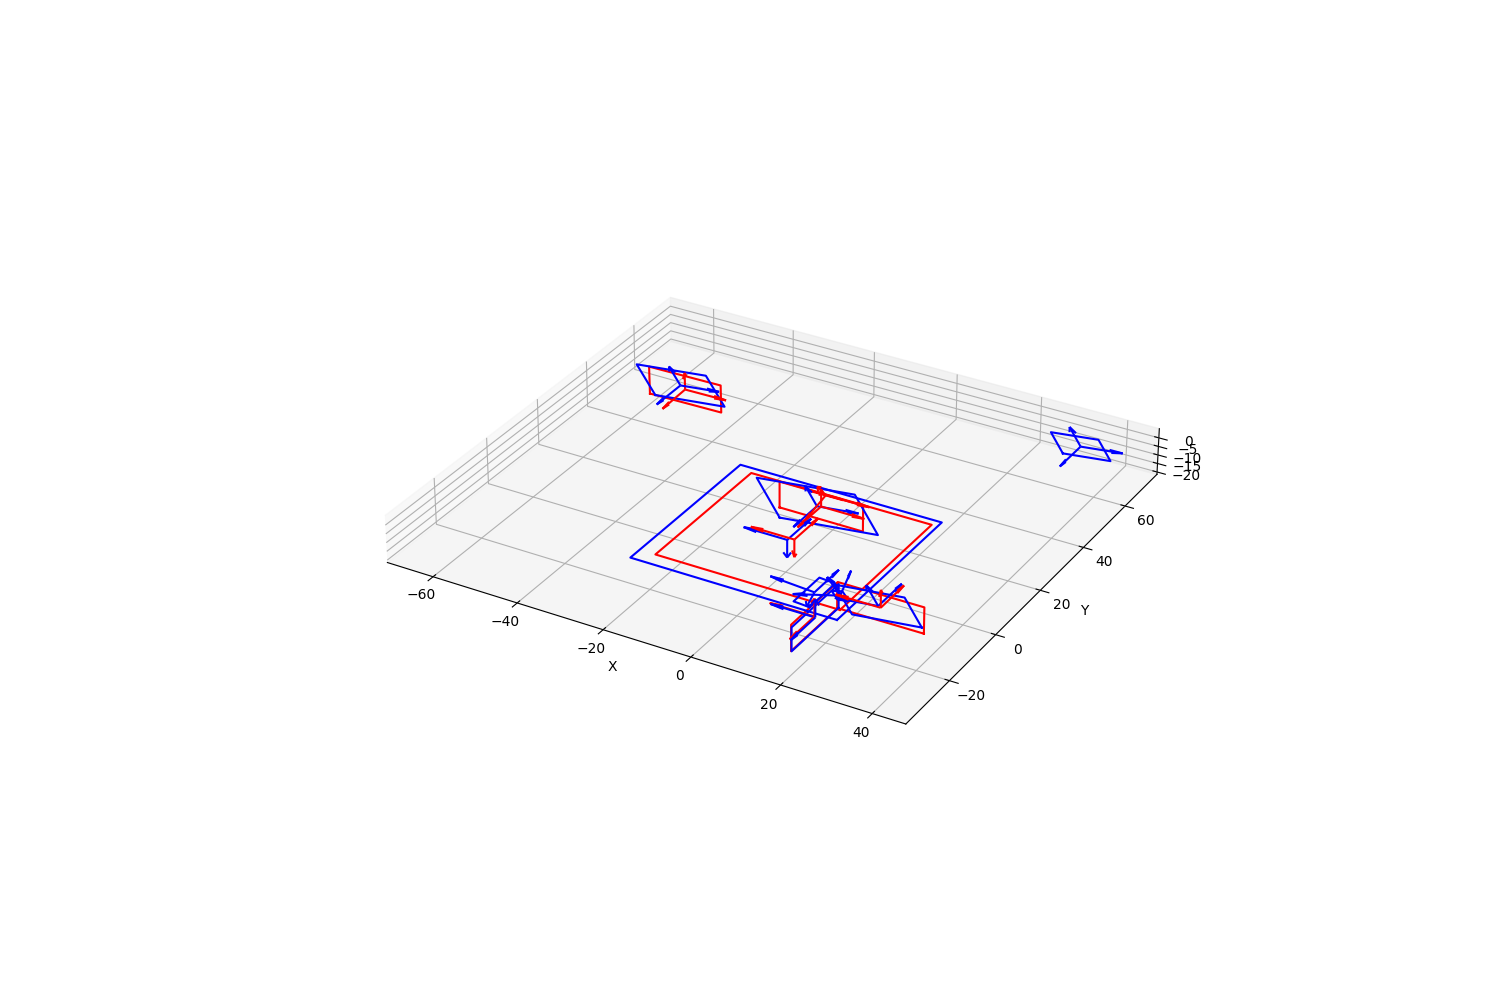

In [6]:
# Plot planesets
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
colors = ['r', 'b']
for i, planes in enumerate(planesets[0:2]):
    for p in planes:
        r = R.from_quat(drone_orientations[i,:])
        p.transform(r.as_matrix(), drone_positions[i,:])
        p.plot(ax, color=colors[i], show_normal=True)
ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [ ]:
for i, p in enumerate(planesets[0]):
    print(i)
    print(" normal: ", np.round(p.normal, 2))
    box, _ = p.to_2D()
    print(" area: ", box.area())
    print(" center: ", p.center)

In [13]:
def merge_scans(P, Q, norm_thresh=0.1, dist_thresh=5.0):
    """Merge scans
    
    Merge scan P into scan Q. (scan = set of planes) 

    Parameters
    ----------
    P : list
        List of planes
    Q : list
        List of planes
    norm_thresh : float 
        Correspodence threshold for comparing normal vectors
    dist_thesh : float
        Correspondence threshold for plane to plane distance
    
    """
    merged_planes = []

    # Keep track of which faces in each scan have been matched
    P_matched = []
    Q_matched = []  

    fig, ax = plt.subplots(6)
    plot_counter = 0

    for i, p in enumerate(P):
        # Compute projection of p onto it's own basis
        p_proj = (np.linalg.inv(p.basis) @ p.vertices.T).T

        for j, q in enumerate(Q):
            
            correspondences = []  # correspondences of planes in scan_2

            # Check if 2 planes are approximately coplanar
            if np.linalg.norm(p.normal - q.normal) < norm_thresh:
                print("normal match ", i, j)
                # Check plane to plane distance    
                if plane_to_plane_dist(p, q) < dist_thresh:
                    print(" p2p dist match")
                    # Check if planes overlap
                    # Project q onto p's basis
                    q_proj = (np.linalg.inv(p.basis) @ q.vertices.T).T
                    p_rect = Rectangle(p_proj[:,0:2])
                    q_rect = Rectangle(q_proj[:,0:2])

                    # Plot for debugging
                    p_rect.plot(ax[plot_counter], color='r'); q_rect.plot(ax[plot_counter], color='b')  
                    plot_counter += 1  

                    # NOTE: skip the overlap check for now - need to implement zonotopes and intersection
                    # Add q to the correspondences set
                    correspondences.append(j)
        
        # Merge correspondences with p
        # Project all to basis of p


            


normal match  0 0
 p2p dist match
normal match  1 1
 p2p dist match
normal match  2 2
 p2p dist match
normal match  3 3
 p2p dist match
normal match  5 1
normal match  5 4
 p2p dist match


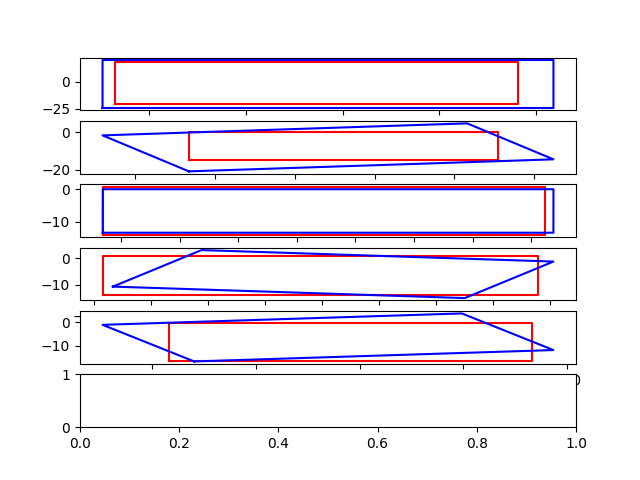

In [14]:
merge_scans(planesets[0], planesets[1])

In [ ]:
def project_plane_to_2D(plane):
    """Project a 3D plane to 2D
    
    Project a (rectangularly bounded) plane that exists in 3D into its 
    2D subspace based on its normal vector.

    Returns
    -------
    np.array (4 x 2)
        Vertices in 2D
    
    """
    # Change basis to plane's basis
    A = np.linalg.inv(plane.basis)
    V = (A @ plane.vertices.T).T
    return V[:,0:2]


In [ ]:
scan_1 = scans[0]
scan_2 = scans[1]

face_1 = scan_1.faces[0]
plane_1 = scan_1.vertices[face_1]
centroid_1 = np.mean(plane_1, axis=0)
normal_1 = scan_1.normals[0]

face_2 = scan_2.faces[0]
plane_2 = scan_2.vertices[face_2]
centroid_2 = np.mean(plane_2, axis=0)
normal_2 = scan_2.normals[0]

geometry.plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2)

In [ ]:
def face_correspondences(scan_1, scan_2, norm_thresh=0.1, dist_thresh=1.0):
    for idx_1, face_1 in enumerate(scan_1.faces):
        # Extract vertices and normal
        plane_1 = scan_1.vertices[face_1]
        normal_1 = scan_1.normals[idx_1]
        for idx_2, face_2 in enumerate(scan_2.faces):
            # Extract vertices and normal
            plane_2 = scan_2.vertices[face_2]
            normal_2 = scan_2.normals[idx_2]
            # Check if 2 planes are approximately coplanar
            if np.linalg.norm(normal_1 - normal_2) < norm_thresh:
                print("norm check")
                # Check plane to plane distance
                p2p_dist = geometry.plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2)
                if p2p_dist < dist_thresh:
                    print("dist check: ", p2p_dist)
                    # TODO: check overlap in plane
                    # Create merged plane
            

In [ ]:
face_correspondences(scans[0], scans[1])

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scans[0].plot(ax, color='b', show_normals=True)
scans[1].plot(ax, color='r', show_normals=True)

# for idx, face in enumerate(scans[0].faces):
#     face_verts = scans[0].vertices[face]
#     c = np.mean(face_verts, axis=0)
#     n = 10*scans[0].normals[idx]
#     ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2], color='b')

# for idx, face in enumerate(scans[1].faces):
#     face_verts = scans[1].vertices[face]
#     c = np.mean(face_verts, axis=0)
#     n = 10*scans[0].normals[idx]
#     ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2], color='b')

ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")